<div align ="center">
<img src="https://github.com/hustvl/EVF-SAM/blob/main/assets/logo.jpg?raw=1" width="20%">
<h1></h1>
<h1><center>📷 EVF-SAM</center></h1>
<h3> Early Vision-Language Fusion for Text-Prompted Segment Anything Model </h3>

[Yuxuan Zhang](https://github.com/CoderZhangYx)<sup>1,\*</sup>, [Tianheng Cheng](https://scholar.google.com/citations?user=PH8rJHYAAAAJ&hl=zh-CN)<sup>1,\*</sup>, Lei Liu<sup>2</sup>, Heng Liu<sup>2</sup>, Longjin Ran<sup>2</sup>, Xiaoxin Chen<sup>2</sup>, [Wenyu Liu](http://eic.hust.edu.cn/professor/liuwenyu)<sup>1</sup>, [Xinggang Wang](https://xwcv.github.io/)<sup>1,📧</sup>

<sup>1</sup> Huazhong University of Science and Technology, <sup>2</sup> vivo AI Lab

(\* equal contribution, 📧 corresponding author)




#### Prerequisites

*   Set HF_TOKEN environment variable for huggingface to download weight file



# EVF-SAM Image Inference

# Installation

In [ ]:
!git clone https://github.com/hustvl/EVF-SAM.git
%cd EVF-SAM
%pip install -r requirements.txt
%pip install matplotlib

In [ ]:
import os
if 'COLAB_GPU' in os.environ:
  # Collab is asking for restart after restart we need to be in directory
  %cd EVF-SAM

## Import python libraries

In [61]:
import os
import sys
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoTokenizer, BitsAndBytesConfig
from model.segment_anything.utils.transforms import ResizeLongestSide
import matplotlib.pyplot as plt

# Set run parameters for inference

In [68]:
VERSION = "YxZhang/evf-sam"
VIS_SAVE_PATH = "./vis"
PRECISION = "fp16" # bf32, fp16, fp32
IMAGE_SIZE = 224
MODEL_MAX_LEN = 512
LOCAL_RANK = 0
LOAD_IN_4BIT = False
LOAD_IN_8BIT = False
MODEL_TYPE = "ori" # ori, effi, sam2
IMAGE_PATH = "assets/zebra.jpg"
PROMPT = "zebra top left"

In [69]:
def sam_preprocess(
    x: np.ndarray,
    pixel_mean=torch.Tensor([123.675, 116.28, 103.53]).view(-1, 1, 1),
    pixel_std=torch.Tensor([58.395, 57.12, 57.375]).view(-1, 1, 1),
    img_size=1024,
    model_type="ori") -> torch.Tensor:
    '''
    preprocess of Segment Anything Model, including scaling, normalization and padding.
    preprocess differs between SAM and Effi-SAM, where Effi-SAM use no padding.
    input: ndarray
    output: torch.Tensor
    '''
    assert img_size==1024, \
        "both SAM and Effi-SAM receive images of size 1024^2, don't change this setting unless you're sure that your employed model works well with another size."
    x = ResizeLongestSide(img_size).apply_image(x)
    resize_shape = x.shape[:2]
    x = torch.from_numpy(x).permute(2,0,1).contiguous()

    # Normalize colors
    x = (x - pixel_mean) / pixel_std
    if model_type=="effi" or model_type=="sam2":
        x = F.interpolate(x.unsqueeze(0), (img_size, img_size), mode="bilinear").squeeze(0)
    else:
        # Pad
        h, w = x.shape[-2:]
        padh = img_size - h
        padw = img_size - w
        x = F.pad(x, (0, padw, 0, padh))
    return x, resize_shape


In [6]:
def beit3_preprocess(x: np.ndarray, img_size=224) -> torch.Tensor:
    '''
    preprocess for BEIT-3 model.
    input: ndarray
    output: torch.Tensor
    '''
    beit_preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((img_size, img_size), interpolation=InterpolationMode.BICUBIC),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    return beit_preprocess(x)

In [73]:
def init_models():
    tokenizer = AutoTokenizer.from_pretrained(
        VERSION,
        padding_side="right",
        use_fast=False,
    )

    torch_dtype = torch.float32
    if PRECISION == "bf16":
        torch_dtype = torch.bfloat16
    elif PRECISION == "fp16":
        torch_dtype = torch.half

    kwargs = {"torch_dtype": torch_dtype}
    if LOAD_IN_4BIT:
        kwargs.update(
            {
                "torch_dtype": torch.half,
                "quantization_config": BitsAndBytesConfig(
                    llm_int8_skip_modules=["visual_model"],
                    load_in_4bit=True,
                    bnb_4bit_compute_dtype=torch.float16,
                    bnb_4bit_use_double_quant=True,
                    bnb_4bit_quant_type="nf4",
                ),
            }
        )
    elif LOAD_IN_8BIT:
        kwargs.update(
            {
                "torch_dtype": torch.half,
                "quantization_config": BitsAndBytesConfig(
                    llm_int8_skip_modules=["visual_model"],
                    load_in_8bit=True,
                ),
            }
        )

    if MODEL_TYPE=="ori":
        from model.evf_sam import EvfSamModel
        model = EvfSamModel.from_pretrained(
            VERSION, low_cpu_mem_usage=True, **kwargs
        )
    elif MODEL_TYPE=="effi":
        from model.evf_effisam import EvfEffiSamModel
        model = EvfEffiSamModel.from_pretrained(
            VERSION, low_cpu_mem_usage=True, **kwargs
        )
    elif MODEL_TYPE=="sam2":
        from model.evf_sam2 import EvfSam2Model
        model = EvfSam2Model.from_pretrained(
            VERSION, low_cpu_mem_usage=True, **kwargs
        )

    if (not LOAD_IN_4BIT) and (not LOAD_IN_8BIT):
        model = model.cuda()
    model.eval()

    return tokenizer, model

## Image Inference

In [70]:
# Clarify IO
if not os.path.exists(IMAGE_PATH):
    print("File not found in {}".format(IMAGE_PATH))
    sys.exit()

os.makedirs(VIS_SAVE_PATH, exist_ok=True)
save_path = "{}/{}_vis.png".format(
    VIS_SAVE_PATH, os.path.basename(IMAGE_PATH).split(".")[0]
)

# Initialize model and tokenizer
tokenizer, model = init_models()
# Preprocess
image_np = cv2.imread(IMAGE_PATH)
image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
original_size_list = [image_np.shape[:2]]

image_beit = beit3_preprocess(image_np, IMAGE_SIZE).to(dtype=model.dtype, device=model.device)
image_sam, resize_shape = sam_preprocess(image_np, model_type=MODEL_TYPE)
image_sam = image_sam.to(dtype=model.dtype, device=model.device)
input_ids = tokenizer(PROMPT, return_tensors="pt")["input_ids"].to(device=model.device)

# inference
pred_mask = model.inference(
    image_sam.unsqueeze(0),
    image_beit.unsqueeze(0),
    input_ids,
    resize_list=[resize_shape],
    original_size_list=original_size_list,
)

pred_mask = pred_mask.detach().cpu().numpy()[0]
pred_mask = pred_mask > 0


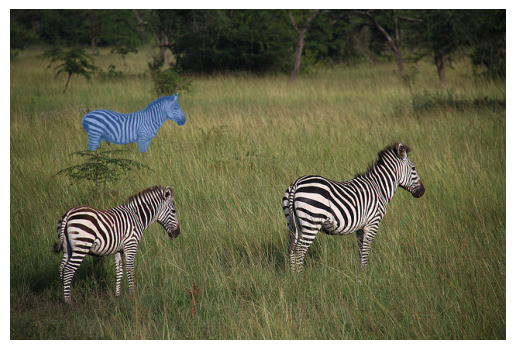

In [71]:
# Show visualization
save_img = image_np.copy()
save_img[pred_mask] = (
    image_np * 0.5
    + pred_mask[:, :, None].astype(np.uint8) * np.array([50, 120, 220]) * 0.5
)[pred_mask]
save_img = cv2.cvtColor(save_img, cv2.COLOR_RGB2BGR)

plt.imshow(cv2.cvtColor(save_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [72]:
# Save visualization
cv2.imwrite(save_path, save_img)
print("Visualization saved at {}".format(save_path))

Visualization saved at ./vis/zebra_vis.png
